# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [4]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from imageio import imread
import datetime
import os
import cv2
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
#train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
#val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())
train_doc = np.random.permutation(open((r'C:\RNN\Project_data\Project_data\train.csv')).readlines())
val_doc = np.random.permutation(open(r'C:\RNN\Project_data\Project_data\val.csv').readlines())
#batch_size = 8 #experiment with the batch size
batch_size = 16

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
#Set the parameters, should be used in model architecture also
#img_idx = [
#        1,2,3,    # Capture gesture initiation
#        8,9,10,   # Early movement
#        14,15,16, # Middle of gesture
#        22,23,24, # Main gesture execution
#        27,28,29  # Gesture completion
#    ]
#img_idx = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] #Denser distribution
#More images
start_frames = [1, 2,3,6]  # Gesture initiation
middle_frames = [8, 9, 10, 14, 15, 16,17,20]  # Early movement & middle
end_frames = [22, 23, 24, 25, 26, 27, 28, 29]  # Gesture completion

#More frames  - 22
# Expanded frame selection for richer gesture representation
#start_frames = [1, 2, 3, 5, 6]  # Gesture initiation
#middle_frames = [8, 9, 10, 13, 14, 15, 16, 18, 20]  # Early movement & middle
#end_frames = [22, 23, 24, 25, 26, 27, 28, 29]  # Gesture completion

# Combine selected frames
img_idx = start_frames + middle_frames + end_frames


y, z = 128, 128  # Desired height and width
target_size = (y, z)
x = len(img_idx)  # Number of frames per video
print(x)
print(img_idx)

20
[1, 2, 3, 6, 8, 9, 10, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 27, 28, 29]


In [8]:
def generator(source_path, folder_list, batch_size):
    print('Source path =', source_path, '; batch size =', batch_size)

    #print('Source path =', source_path, '; batch size =', batch_size)
    print('Number of folders:', len(folder_list))  # Debug print
    
    # Validate inputs
    if folder_list.size == 0:  # Check if folder_list is empty
        raise ValueError("folder_list is empty")
    

    
    #if not os.path.exists(source_path):
    #    raise ValueError(f"Source path does not exist: {source_path}")
    
    #img_idx = [1,5,6,7,8,9,13,15,17,20,22,24,25,27,30]
    img_idx = [1, 2, 3, 6, 8, 9, 10, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 27, 28, 29]
    #img_idx = [1, 2, 3, 5, 6, 8, 9, 10, 13, 14, 15, 16, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29]
    
    y, z = 128, 128  # Desired height and width
    target_size = (y, z)
    x = len(img_idx)  # Number of frames per video

    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size
        
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, x, y, z, 3))
            batch_labels = np.zeros((batch_size, 5))
            
            for folder in range(batch_size):
                #folder_path = os.path.normpath((os.path.join(source_path, t[folder + (batch * batch_size)].strip().split(';')[0])))
                folder_name = t[folder + (batch * batch_size)].strip().split(';')[0]
                folder_path = os.path.join(source_path, folder_name)
                folder_path = os.path.normpath(folder_path)  # Ensure a consistent path format

                imgs = os.listdir(folder_path)
                
                for idx, item in enumerate(img_idx):
                    if item >= len(imgs):
                        print(f"Warning: Frame {item} not found in folder, skipping...")
                        continue
                    
                    image = imread(os.path.join(folder_path, imgs[item])).astype(np.float32)
                    
                    # Crop to square and resize
                    if image.shape[1] > image.shape[0]:
                        crop_start = (image.shape[1] - image.shape[0]) // 2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        crop_start = (image.shape[0] - image.shape[1]) // 2
                        crop_end = crop_start + image.shape[1]
                        image = image[crop_start:crop_end, :]

                    image_resized = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)

                    # Augmentation: Horizontal flip and brightness adjustment
                    if rn.choice([True, False]):  # Random horizontal flip
                        image_resized = cv2.flip(image_resized, 1)
                    
                    brightness_factor = 0.8 + 0.4 * rn.random()  # Random brightness factor
                    image_resized = np.clip(image_resized * brightness_factor, 0, 255)

                    # Normalize each channel
                    mean_r, mean_g, mean_b = image_resized[:, :, 0].mean(), image_resized[:, :, 1].mean(), image_resized[:, :, 2].mean()
                    std_r, std_g, std_b = image_resized[:, :, 0].std(), image_resized[:, :, 1].std(), image_resized[:, :, 2].std()

                    batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0] - mean_r) / (std_r + 1e-7)
                    batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1] - mean_g) / (std_g + 1e-7)
                    batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2] - mean_b) / (std_b + 1e-7)
                
                # Set one-hot encoded label
                label_index = int(t[folder + (batch * batch_size)].strip().split(';')[2])
                batch_labels[folder, label_index] = 1
            
            yield batch_data, batch_labels  # Yield the batch

        # Process remaining data points
        remaining_datapoints = len(folder_list) % batch_size
        if remaining_datapoints > 0:
            batch_data = np.zeros((remaining_datapoints, x, y, z, 3))
            batch_labels = np.zeros((remaining_datapoints, 5))
            start_index = num_batches * batch_size
            
            for folder in range(remaining_datapoints):
                #folder_path = os.path.normpath(os.path.join(source_path, t[folder + start_index].strip().split(';')[0]))
                folder_name = t[folder + start_index].strip().split(';')[0]
                folder_path = os.path.join(source_path, folder_name)
                folder_path = os.path.normpath(folder_path)  # Ensure a consistent path format

                imgs = os.listdir(folder_path)
                
                for idx, item in enumerate(img_idx):
                    if item >= len(imgs):
                        print(f"Warning: Frame {item} not found in folder, skipping...")
                        continue
                    
                    image = imread(os.path.join(folder_path, imgs[item])).astype(np.float32)
                    
                    # Crop to square and resize
                    if image.shape[1] > image.shape[0]:
                        crop_start = (image.shape[1] - image.shape[0]) // 2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        crop_start = (image.shape[0] - image.shape[1]) // 2
                        crop_end = crop_start + image.shape[1]
                        image = image[crop_start:crop_end, :]

                    image_resized = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)

                    # Augmentation
                    if rn.choice([True, False]):
                        image_resized = cv2.flip(image_resized, 1)
                    
                    brightness_factor = 0.8 + 0.4 * rn.random()
                    image_resized = np.clip(image_resized * brightness_factor, 0, 255)

                    # Normalize each channel
                    mean_r, mean_g, mean_b = image_resized[:, :, 0].mean(), image_resized[:, :, 1].mean(), image_resized[:, :, 2].mean()
                    std_r, std_g, std_b = image_resized[:, :, 0].std(), image_resized[:, :, 1].std(), image_resized[:, :, 2].std()

                    batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0] - mean_r) / (std_r + 1e-7)
                    batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1] - mean_g) / (std_g + 1e-7)
                    batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2] - mean_b) / (std_b + 1e-7)
                
                label_index = int(t[folder + start_index].strip().split(';')[2])
                batch_labels[folder, label_index] = 1
            
            yield batch_data, batch_labels  # Yield the remaining batch


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = r'C:\RNN\Project_data\Project_data\train'
val_path = r'C:\RNN\Project_data\Project_data\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Experiment 1 : Conv2D + LSTM, 15 frames

In [107]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
#from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Conv3D,MaxPooling3D
#from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

# Define input shape (frames, height, width, channels)
input_shape = (15, 128, 128, 3)
num_classes = 5

model = Sequential()

# First Conv2D Block - More aggressive pooling
model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling2D((4, 4))))  # More aggressive pooling

# Second Conv2D Block
model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.25)))

# Flatten and LSTM
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64))
model.add(Dense(num_classes, activation='softmax'))



Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [108]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_73                  │ (None, 15, 128, 128, 16)    │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_74                  │ (None, 15, 128, 128, 16)    │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_75                  │ (None, 15, 128, 128, 16)    │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_76                  │ (None, 15, 32, 32, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_77                  │ (None, 15, 32, 32, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_78                  │ (None, 15, 32, 32, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_79                  │ (None, 15, 32, 32, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_80                  │ (None, 15, 16, 16, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_81                  │ (None, 15, 16, 16, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_82                  │ (None, 15, 8192)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │       2,113,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,119,397 (8.08 MB)

 Trainable params: 2,119,301 (8.08 MB)

 Non-trainable params: 96 (384.00 B)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [109]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [131]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

#LR = # write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [111]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print(steps_per_epoch,validation_steps)

83 13


In [112]:
# At the start of your script, let's print folder contents
#print("Checking paths and data...")
#print(f"Train path exists: {os.path.exists(train_path)}")
"""print(f"Val path exists: {os.path.exists(val_path)}")
print(f"Length of train_doc: {len(train_doc)}")
print(f"Length of val_doc: {len(val_doc)}")
print(type(train_doc))
#print(train_doc)

# Before creating generators, let's verify batch_size is defined
if 'batch_size' not in locals():
    batch_size = 32  # or whatever default you want
print(f"Batch size: {batch_size}")

# Let's modify your generator creation to include try-except
try:
    print("Creating train generator...")
    train_generator = generator(train_path, train_doc, batch_size)
    # Verify generator works by getting first batch
    print("Testing train generator...")
    first_batch = next(train_generator)
    print("Train generator successfully created and tested")
except Exception as e:
    print(f"Error with train generator: {str(e)}")
    raise

try:
    print("Creating validation generator...")
    val_generator = generator(val_path, val_doc, batch_size)
    # Verify generator works by getting first batch
    print("Testing validation generator...")
    first_batch = next(val_generator)
    print("Validation generator successfully created and tested")
except Exception as e:
    print(f"Error with validation generator: {str(e)}")
    raise

# Print your steps calculations
print(f"Number of train sequences: {num_train_sequences}")
print(f"Number of val sequences: {num_val_sequences}")
print(f"Calculated steps_per_epoch: {steps_per_epoch}")
print(f"Calculated validation_steps: {validation_steps}")

# Then proceed with your model.fit()"""

'print(f"Val path exists: {os.path.exists(val_path)}")\nprint(f"Length of train_doc: {len(train_doc)}")\nprint(f"Length of val_doc: {len(val_doc)}")\nprint(type(train_doc))\n#print(train_doc)\n\n# Before creating generators, let\'s verify batch_size is defined\nif \'batch_size\' not in locals():\n    batch_size = 32  # or whatever default you want\nprint(f"Batch size: {batch_size}")\n\n# Let\'s modify your generator creation to include try-except\ntry:\n    print("Creating train generator...")\n    train_generator = generator(train_path, train_doc, batch_size)\n    # Verify generator works by getting first batch\n    print("Testing train generator...")\n    first_batch = next(train_generator)\n    print("Train generator successfully created and tested")\nexcept Exception as e:\n    print(f"Error with train generator: {str(e)}")\n    raise\n\ntry:\n    print("Creating validation generator...")\n    val_generator = generator(val_path, val_doc, batch_size)\n    # Verify generator works by

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [113]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path = C:\RNN\Project_data\Project_data\train ; batch size = 8
Source path = C:\RNN\Project_data\Project_data\train ; batch size = 8
Number of folders: 663


C:\Users\azure\AppData\Local\Temp\2\ipykernel_4952\3569686123.py:50: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(folder_path, imgs[item])).astype(np.float32)


Epoch 1/10
 1/83 ━━━━━━━━━━━━━━━━━━━━ 24:18 18s/step - categorical_accuracy: 0.3750 - loss: 1.6174Warning: Frame 30 not found in folder, skipping...
 2/83 ━━━━━━━━━━━━━━━━━━━━ 56s 693ms/step - categorical_accuracy: 0.3438 - loss: 1.6242Warning: Frame 30 not found in folder, skipping...
 3/83 ━━━━━━━━━━━━━━━━━━━━ 1:41 1s/step - categorical_accuracy: 0.3542 - loss: 1.6267  Warning: Frame 30 not found in folder, skipping...
 4/83 ━━━━━━━━━━━━━━━━━━━━ 1:53 1s/step - categorical_accuracy: 0.3516 - loss: 1.6273Warning: Frame 30 not found in folder, skipping...
 5/83 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - categorical_accuracy: 0.3462 - loss: 1.6400Warning: Frame 30 not found in folder, skipping...
 6/83 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - categorical_accuracy: 0.3406 - loss: 1.6551Warning: Frame 30 not found in folder, skipping...
 7/83 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - categorical_accuracy: 0.3328 - loss: 1.6640Warning: Frame 30 not found in folder, skipping...
 8/83 ━━━━━━━━━━━━━━━━━━━━ 2:05

C:\Users\azure\AppData\Local\Temp\2\ipykernel_4952\3569686123.py:105: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(folder_path, imgs[item])).astype(np.float32)


82/83 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - categorical_accuracy: 0.2206 - loss: 1.7162Warning: Frame 30 not found in folder, skipping...
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2204 - loss: 1.7156Source path = C:\RNN\Project_data\Project_data\val ; batch size = 8
Source path = C:\RNN\Project_data\Project_data\val ; batch size = 8
Number of folders: 100

Epoch 1: saving model to model_init_2024-11-0413_57_54.462017/model-00001-1.66327-0.20060-1.64743-0.23000.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - categorical_accuracy: 0.2201 - loss: 1.7149 - val_categorical_accuracy: 0.2300 - val_loss: 1.6474 - learning_rate: 0.0010
Epoch 2/10
 1/83 ━━━━━━━━━━━━━━━━━━━━ 58s 712ms/step - categorical_accuracy: 0.5000 - loss: 1.5648Warning: Frame 30 not found in folder, skipping...

 2/83 ━━━━━━━━━━━━━━━━━━━━ 57s 708ms/step - categorical_accuracy: 0.4062 - loss: 1.5681Warning: Frame 30 not found in folder, skipping...
 3/83 ━━━━━━━━━━━━━━━━━━━━ 58s 734ms/step - categorical_acc

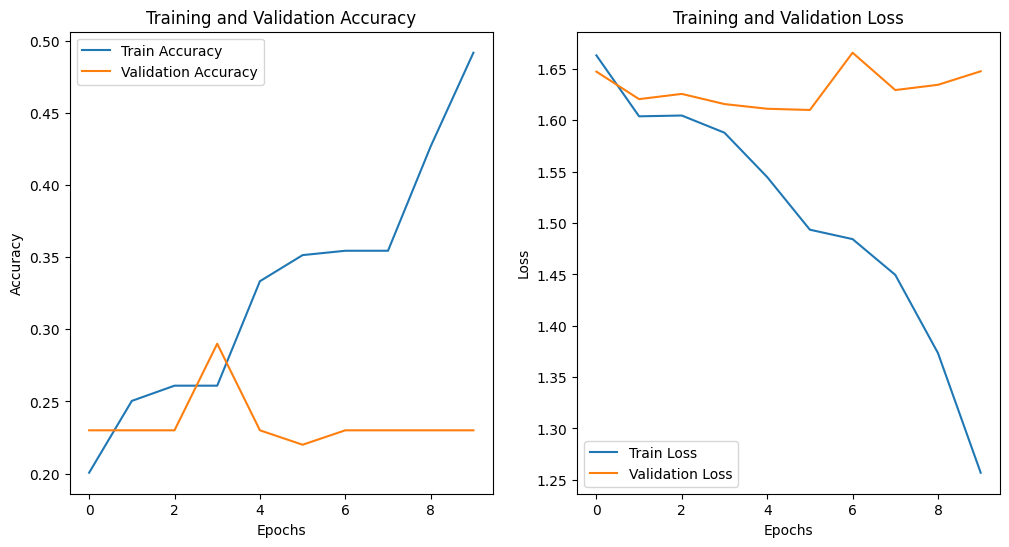

In [114]:
# Plotting function
def plot_training(history):
    plt.figure(figsize=(12, 6))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_training(history)

#### Model 2 CONV2D + RNN  (more complex)

In [135]:
# Updated model architecture
model = Sequential()

# First Conv2D Block
model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

# Second Conv2D Block
model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.25)))

# Third Conv2D Block
model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.25)))

# Flatten and LSTM
model.add(TimeDistributed(Flatten()))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


In [142]:
from tensorflow.keras.optimizers import Adam
#learning_rate = 0.0001
optimizer = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_98                  │ (None, 15, 128, 128, 16)    │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_99                  │ (None, 15, 128, 128, 16)    │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_100                 │ (None, 15, 128, 128, 16)    │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_101                 │ (None, 15, 64, 64, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_102                 │ (None, 15, 64, 64, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_103                 │ (None, 15, 64, 64, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_104                 │ (None, 15, 64, 64, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_105                 │ (None, 15, 32, 32, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_106                 │ (None, 15, 32, 32, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_107                 │ (None, 15, 32, 32, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_108                 │ (None, 15, 32, 32, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_109                 │ (None, 15, 32, 32, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_110                 │ (None, 15, 16, 16, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_111                 │ (None, 15, 16, 16, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,479,333 (32.35 MB)

 Trainable params: 8,479,109 (32.35 MB)

 Non-trainable params: 224 (896.00 B)

None


In [138]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [139]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print(steps_per_epoch,validation_steps)

42 7


In [140]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path = C:\RNN\Project_data\Project_data\train ; batch size = 16
Number of folders: 663


C:\Users\azure\AppData\Local\Temp\2\ipykernel_4952\2517287132.py:50: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(folder_path, imgs[item])).astype(np.float32)


Epoch 1/10
40/42 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - categorical_accuracy: 0.2065 - loss: 1.8259 

C:\Users\azure\AppData\Local\Temp\2\ipykernel_4952\2517287132.py:105: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(folder_path, imgs[item])).astype(np.float32)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2055 - loss: 1.8252Source path = C:\RNN\Project_data\Project_data\val ; batch size = 16
Number of folders: 100

Epoch 1: saving model to model_init_2024-11-0414_44_40.445612/model-00001-1.81510-0.18552-1.60798-0.23000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 208s 5s/step - categorical_accuracy: 0.2050 - loss: 1.8250 - val_categorical_accuracy: 0.2300 - val_loss: 1.6080 - learning_rate: 0.0010
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.1982 - loss: 1.7812
Epoch 2: saving model to model_init_2024-11-0414_44_40.445612/model-00002-1.76147-0.20965-1.59180-0.21000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - categorical_accuracy: 0.1985 - loss: 1.7807 - val_categorical_accuracy: 0.2100 - val_loss: 1.5918 - learning_rate: 0.0010
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2215 - loss: 1.7591
Epoch 3: saving model to model_init_2024-11-0414_44_40.445612/model-00003-1.75431-

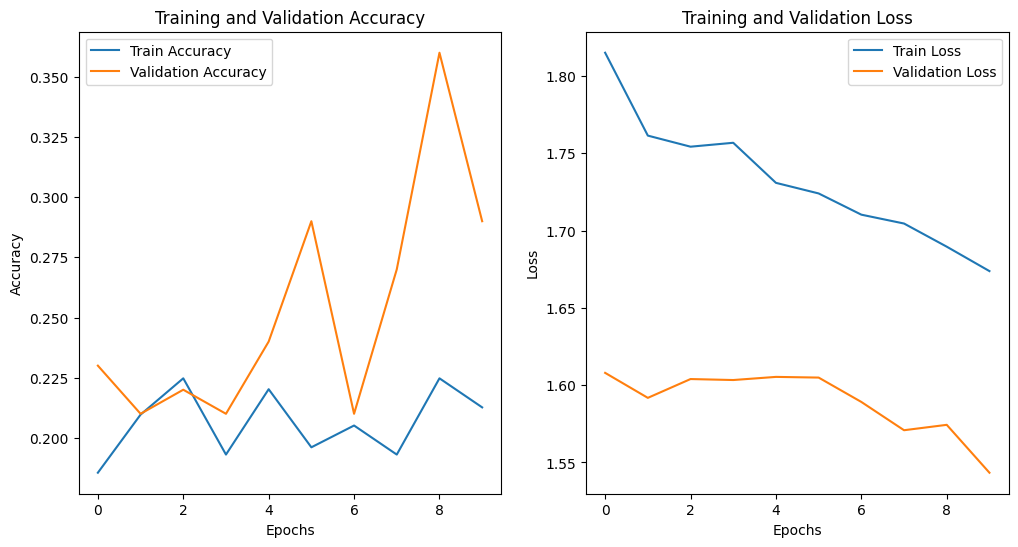

In [151]:
plot_training(history)

##### Exp 2 - Extremely low accuracy 

### Experiment 3 Conv2D + LSTM, mor images, increased filters
Will select more images, back to same learning rate, changes in model Architecture, increased filters


In [152]:
# Define input shape (frames, height, width, channels)
input_shape = (20, 128, 128, 3)
num_classes = 5

# Updated model architecture
model = Sequential()

# First Conv2D Block
model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same'), input_shape=input_shape))  # Increased filters
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

# Second Conv2D Block
model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))  # Increased filters
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.2)))  # Adjusted dropout

# Third Conv2D Block
model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same')))  # Increased filters
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.3)))  # Adjusted dropout

# Flatten and LSTM
model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=False))  # Increased LSTM units
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with a lower learning rate
#model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [153]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_113                 │ (None, 20, 128, 128, 32)    │             896 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_114                 │ (None, 20, 128, 128, 32)    │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_115                 │ (None, 20, 128, 128, 32)    │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_116                 │ (None, 20, 64, 64, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_117                 │ (None, 20, 64, 64, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_118                 │ (None, 20, 64, 64, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_119                 │ (None, 20, 64, 64, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_120                 │ (None, 20, 32, 32, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_121                 │ (None, 20, 32, 32, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_122                 │ (None, 20, 32, 32, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_123                 │ (None, 20, 32, 32, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_124                 │ (None, 20, 32, 32, 128)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_125                 │ (None, 20, 16, 16, 128)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_126                 │ (None, 20, 16, 16, 128)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,913,029 (129.37 MB)

 Trainable params: 33,912,581 (129.37 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [154]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [155]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print(steps_per_epoch,validation_steps)

42 7


In [156]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path = C:\RNN\Project_data\Project_data\train ; batch size = 16
Number of folders: 663


C:\Users\azure\AppData\Local\Temp\2\ipykernel_4952\244897765.py:50: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(folder_path, imgs[item])).astype(np.float32)


Epoch 1/20
40/42 ━━━━━━━━━━━━━━━━━━━━ 17s 9s/step - categorical_accuracy: 0.1963 - loss: 2.1153

C:\Users\azure\AppData\Local\Temp\2\ipykernel_4952\244897765.py:105: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(folder_path, imgs[item])).astype(np.float32)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.1965 - loss: 2.1062Source path = C:\RNN\Project_data\Project_data\val ; batch size = 16
Number of folders: 100

Epoch 1: saving model to model_init_2024-11-0414_44_40.445612/model-00001-1.92198-0.19910-1.60578-0.29000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 418s 9s/step - categorical_accuracy: 0.1965 - loss: 2.1019 - val_categorical_accuracy: 0.2900 - val_loss: 1.6058 - learning_rate: 0.0010
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.1990 - loss: 1.8237
Epoch 2: saving model to model_init_2024-11-0414_44_40.445612/model-00002-1.77182-0.21569-1.60673-0.24000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 317s 8s/step - categorical_accuracy: 0.1994 - loss: 1.8225 - val_categorical_accuracy: 0.2400 - val_loss: 1.6067 - learning_rate: 0.0010
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.2237 - loss: 1.7637
Epoch 3: saving model to model_init_2024-11-0414_44_40.445612/model-00003-1.78315-

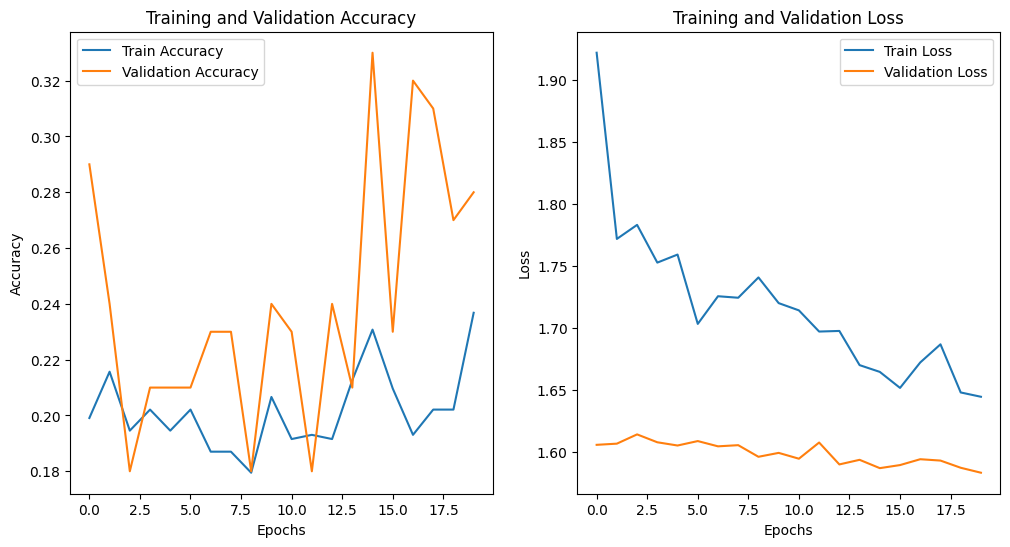

In [157]:
plot_training(history)

Above one gave better results with 20 epochs. So we will do 20 epochs atleast. 
Also will try to reduce the model complexity and see once.

#### Exp 4 - Conv3D + GRU

In [158]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, GRU, Dense
from tensorflow.keras.optimizers import Adam

# Define input shape and parameters
input_shape = (20, 128, 128, 3)  # 20 frames
num_classes = 5

# Initialize Sequential model
model = Sequential()

# First Conv2D Block
model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.2)))  # Moderate dropout

# Second Conv2D Block
model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.3)))  # Adjusted dropout to reduce overfitting

# Third Conv2D Block
model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.3)))

# Fourth Conv2D Block (if needed, you can remove this if the model is still complex)
model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.4)))  # Higher dropout to improve generalization

# Flatten and GRU
model.add(TimeDistributed(Flatten()))
model.add(GRU(128, return_sequences=False))  # Reduced GRU units for efficiency
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Summary of the model
model.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_128                 │ (None, 20, 128, 128, 32)    │             896 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_129                 │ (None, 20, 128, 128, 32)    │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_130                 │ (None, 20, 64, 64, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_131                 │ (None, 20, 64, 64, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_132                 │ (None, 20, 64, 64, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_133                 │ (None, 20, 64, 64, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_134                 │ (None, 20, 32, 32, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_135                 │ (None, 20, 32, 32, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_136                 │ (None, 20, 32, 32, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_137                 │ (None, 20, 32, 32, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_138                 │ (None, 20, 16, 16, 128)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_139                 │ (None, 20, 16, 16, 128)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_140                 │ (None, 20, 16, 16, 256)     │         295,168 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_141                 │ (None, 20, 16, 16, 256)     │           1,024 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,732,357 (25.68 MB)

 Trainable params: 6,731,397 (25.68 MB)

 Non-trainable params: 960 (3.75 KB)

In [159]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [160]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print(steps_per_epoch,validation_steps)
print(num_epochs)

42 7
20


In [161]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path = C:\RNN\Project_data\Project_data\train ; batch size = 16
Number of folders: 663


C:\Users\azure\AppData\Local\Temp\2\ipykernel_4952\244897765.py:50: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(folder_path, imgs[item])).astype(np.float32)


Epoch 1/20
40/42 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - categorical_accuracy: 0.2204 - loss: 2.1206

C:\Users\azure\AppData\Local\Temp\2\ipykernel_4952\244897765.py:105: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(folder_path, imgs[item])).astype(np.float32)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.2227 - loss: 2.1130Source path = C:\RNN\Project_data\Project_data\val ; batch size = 16
Number of folders: 100

Epoch 1: saving model to model_init_2024-11-0414_44_40.445612/model-00001-1.95973-0.26998-1.41547-0.50000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 384s 8s/step - categorical_accuracy: 0.2238 - loss: 2.1094 - val_categorical_accuracy: 0.5000 - val_loss: 1.4155 - learning_rate: 1.0000e-04
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.3372 - loss: 1.6483
Epoch 2: saving model to model_init_2024-11-0414_44_40.445612/model-00002-1.66469-0.34992-1.53206-0.47000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 256s 6s/step - categorical_accuracy: 0.3375 - loss: 1.6487 - val_categorical_accuracy: 0.4700 - val_loss: 1.5321 - learning_rate: 1.0000e-04
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.3674 - loss: 1.6008
Epoch 3: saving model to model_init_2024-11-0414_44_40.445612/model-00003-

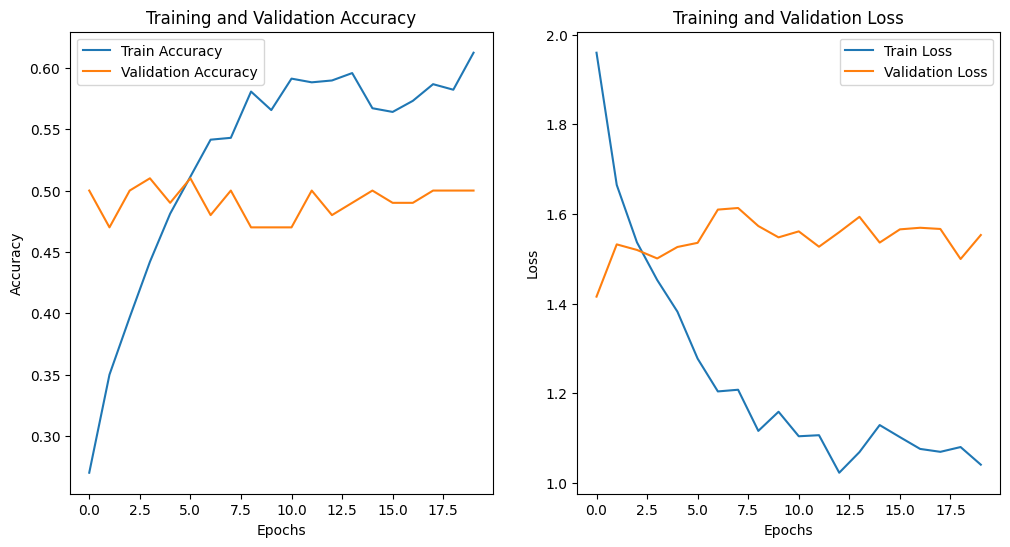

In [162]:
plot_training(history)

The pattern in the results suggests that while the model's training accuracy improves, the validation accuracy remains stagnant at around 50%. This hints at possible overfitting or issues in the model's capacity to generalize effectively. Here are some adjustments to try:

Experiment with More Layers: Consider adding an additional Conv2D block with fewer filters (to keep memory usage in check) to capture more nuanced spatial features before passing data to the GRU.

Reduce Conv2D Filter Sizes: Try smaller filter sizes (e.g., (3, 3) and (2, 2)) in initial layers to improve feature granularity.

Tweak Dropout: Increasing dropout in both Conv2D and GRU layers can help generalization. Using SpatialDropout2D after Conv2D layers may also help, as it drops entire feature maps, encouraging robust feature extraction.

Early Stop & LR Tuning: Since the learning rate already reduces, consider early stopping based on validation loss if the accuracy doesn't increase after a set number of epochs.


#### EXP 4 - Conv2D + GRU, more epochs, improved Generalization with SpacialDropout, an additional Conv2D layers

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, GRU, Dense, SpatialDropout2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Define input shape and parameters
input_shape = (20, 128, 128, 3)  # 
num_classes = 5

# Initialize Sequential model
model = Sequential()

# First Conv2D Block
model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(SpatialDropout2D(0.2)))  # Improved generalization

# Second Conv2D Block
model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(SpatialDropout2D(0.3)))

# Third Conv2D Block (additional layer for deeper feature extraction)
model.add(TimeDistributed(Conv2D(128, (2, 2), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(SpatialDropout2D(0.3)))

# Fourth Conv2D Block
model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.4)))

# Flatten and GRU
model.add(TimeDistributed(Flatten()))
model.add(GRU(128, return_sequences=False))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Summary of the model
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_34                  │ (None, 20, 128, 128, 32)    │             896 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_35                  │ (None, 20, 128, 128, 32)    │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_36                  │ (None, 20, 64, 64, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_37                  │ (None, 20, 64, 64, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_38                  │ (None, 20, 64, 64, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_39                  │ (None, 20, 64, 64, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_40                  │ (None, 20, 32, 32, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_41                  │ (None, 20, 32, 32, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_42                  │ (None, 20, 32, 32, 128)     │          32,896 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_43                  │ (None, 20, 32, 32, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_44                  │ (None, 20, 16, 16, 128)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_45                  │ (None, 20, 16, 16, 128)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_46                  │ (None, 20, 16, 16, 256)     │         131,328 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_47                  │ (None, 20, 16, 16, 256)     │           1,024 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,527,557 (24.90 MB)

 Trainable params: 6,526,597 (24.90 MB)

 Non-trainable params: 960 (3.75 KB)

In [17]:
# Modify ReduceLROnPlateau with increased patience and slight factor adjustment
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, min_lr=1e-6, verbose=1)
callbacks_list = [checkpoint, LR]

In [18]:
#increase epochs
num_epochs = 40

In [19]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print(steps_per_epoch,validation_steps)
print(num_epochs)

42 7
40


In [21]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path = C:\RNN\Project_data\Project_data\train ; batch size = 16
Number of folders: 663


C:\Users\azure\AppData\Local\Temp\2\ipykernel_10616\3298761367.py:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(folder_path, imgs[item])).astype(np.float32)


Epoch 1/40
40/42 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - categorical_accuracy: 0.2163 - loss: 2.1079

C:\Users\azure\AppData\Local\Temp\2\ipykernel_10616\3298761367.py:101: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(folder_path, imgs[item])).astype(np.float32)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.2185 - loss: 2.1009Source path = C:\RNN\Project_data\Project_data\val ; batch size = 16
Number of folders: 100

Epoch 1: saving model to model_init_2024-11-0612_00_52.169849/model-00001-1.95389-0.26546-1.22386-0.55000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 343s 7s/step - categorical_accuracy: 0.2196 - loss: 2.0975 - val_categorical_accuracy: 0.5500 - val_loss: 1.2239 - learning_rate: 1.0000e-04
Epoch 2/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.3585 - loss: 1.6542
Epoch 2: saving model to model_init_2024-11-0612_00_52.169849/model-00002-1.64269-0.36652-1.16822-0.56000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 245s 6s/step - categorical_accuracy: 0.3587 - loss: 1.6539 - val_categorical_accuracy: 0.5600 - val_loss: 1.1682 - learning_rate: 1.0000e-04
Epoch 3/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.3962 - loss: 1.6021
Epoch 3: saving model to model_init_2024-11-0612_00_52.169849/model-00003-

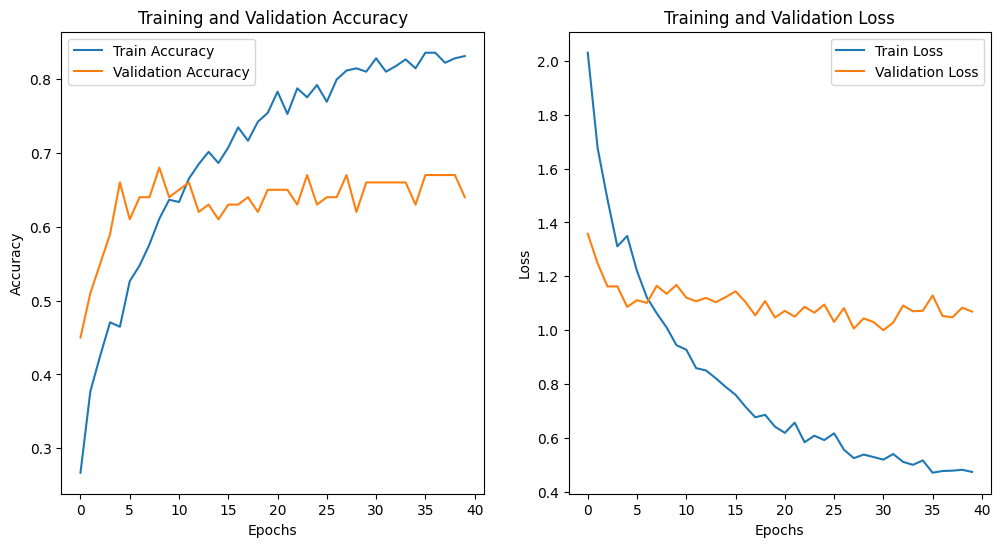

In [169]:
plot_training(history)

Results:
Training accuracy improved substancially to 86%, but validation accuracy is ppears to be plateauing around 72-73%.

Will try Conv3d with some adjustments
1) Add a bit more frames 20 to 22
2) Finetune ReduceLROnPlateau, increase patience for stability
3) Try Conv3D

#### Experiment 5 - Conv3D

In [179]:
from tensorflow.keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Dropout, Flatten, Dense


# Define input shape and parameters
input_shape = (22, 128, 128, 3)  # Adjust as per frame count, image size, and channels
num_classes = 5

# Initialize Sequential model
model = Sequential()

# First Conv3D Block
model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.2))

# Second Conv3D Block
model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.3))

# Third Conv3D Block
model.add(Conv3D(128, (2, 2, 2), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.3))

# Fourth Conv3D Block
model.add(Conv3D(256, (2, 2, 2), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.4))

# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


In [180]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [181]:
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_16 (Conv3D)                   │ (None, 22, 128, 128, 32)    │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 22, 128, 128, 32)    │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_16 (MaxPooling3D)      │ (None, 11, 64, 64, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 11, 64, 64, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_17 (Conv3D)                   │ (None, 11, 64, 64, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_51               │ (None, 11, 64, 64, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_17 (MaxPooling3D)      │ (None, 5, 32, 32, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 5, 32, 32, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_18 (Conv3D)                   │ (None, 5, 32, 32, 128)      │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_52               │ (None, 5, 32, 32, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_18 (MaxPooling3D)      │ (None, 2, 16, 16, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 2, 16, 16, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_19 (Conv3D)                   │ (None, 2, 16, 16, 256)      │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_53               │ (None, 2, 16, 16, 256)      │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_19 (MaxPooling3D)      │ (None, 1, 8, 8, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 1, 8, 8, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,779,653 (33.49 MB)

 Trainable params: 8,778,693 (33.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [187]:
# Fine-tuned ReduceLROnPlateau for gradual learning rate adjustment
LR = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,       # Slightly more conservative reduction
    patience=5,       # Increased patience for stability
    min_lr=1e-6, 
    verbose=1
)

checkpoint = ModelCheckpoint(filepath='model_init_{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.keras',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1)

callbacks_list = [checkpoint, LR]

In [188]:
curr_dt_time = datetime.datetime.now()
train_path = r'C:\RNN\Project_data\Project_data\train'
val_path = r'C:\RNN\Project_data\Project_data\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 40
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 40


In [189]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [190]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print(steps_per_epoch,validation_steps)


42 7


In [191]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path = C:\RNN\Project_data\Project_data\train ; batch size = 16
Number of folders: 663


C:\Users\azure\AppData\Local\Temp\2\ipykernel_4952\487364053.py:44: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(folder_path, imgs[item])).astype(np.float32)


Epoch 1/40
40/42 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.3389 - loss: 2.3617 

C:\Users\azure\AppData\Local\Temp\2\ipykernel_4952\487364053.py:99: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(folder_path, imgs[item])).astype(np.float32)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3395 - loss: 2.3466Source path = C:\RNN\Project_data\Project_data\val ; batch size = 16
Number of folders: 100

Epoch 1: val_loss improved from inf to 2.81948, saving model to model_init_00001-2.04213-0.35143-2.81948-0.39000.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 211s 5s/step - accuracy: 0.3398 - loss: 2.3395 - val_accuracy: 0.3900 - val_loss: 2.8195 - learning_rate: 0.0010
Epoch 2/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3758 - loss: 1.6394
Epoch 2: val_loss did not improve from 2.81948
42/42 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.3762 - loss: 1.6388 - val_accuracy: 0.2300 - val_loss: 22.1241 - learning_rate: 0.0010
Epoch 3/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4184 - loss: 1.5826
Epoch 3: val_loss did not improve from 2.81948
42/42 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.4185 - loss: 1.5795 - val_accuracy: 0.2100 - val_loss: 30.6598 - learning_rate: 0.0010
Epoch 4/40
42/42 ━━━━━━━━━━━━━━━━━━━━

It looks like model has a good start but is struggling to generalize to the validation set, resulting in a high validation loss and inconsistent validation accuracy. This issue often arises due to overfitting or insufficient feature extraction in earlier layers.

Add more convolutional layers , increase filter sizes
Add a TimeDistributed Layer with an RNN
Lower Dropout Values

learning rate might be too high even with ReduceLROnPlateau

#### Exp 6 - Conv3D + RNN
starting with a slightly lower initial learning rate, such as 1e-4
Decrease patience



In [192]:
from tensorflow.keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Dropout, Flatten, Dense, TimeDistributed, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Define input shape and parameters
input_shape = (22, 128, 128, 3)  # Adjust as per frame count, image size, and channels
num_classes = 5

# Initialize Sequential model
model = Sequential()

# Conv3D Blocks
model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.2))

model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.3))

model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.3))

model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.4))

# Adding TimeDistributed wrapper and RNN for temporal features
model.add(TimeDistributed(Flatten()))
model.add(GRU(128, return_sequences=False, dropout=0.3))

# Fully Connected Layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


In [193]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)  # Lower initial learning rate for gradual optimization
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [194]:
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_20 (Conv3D)                   │ (None, 22, 128, 128, 32)    │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 22, 128, 128, 32)    │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_20 (MaxPooling3D)      │ (None, 11, 64, 64, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 11, 64, 64, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_21 (Conv3D)                   │ (None, 11, 64, 64, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 11, 64, 64, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_21 (MaxPooling3D)      │ (None, 5, 32, 32, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 5, 32, 32, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_22 (Conv3D)                   │ (None, 5, 32, 32, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 5, 32, 32, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_22 (MaxPooling3D)      │ (None, 2, 16, 16, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 2, 16, 16, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_23 (Conv3D)                   │ (None, 2, 16, 16, 256)      │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 2, 16, 16, 256)      │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_23 (MaxPooling3D)      │ (None, 1, 8, 8, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 1, 8, 8, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_162                 │ (None, 1, 16384)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 128)                 │       6,341,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 512)                 │          66,0

 Total params: 7,576,197 (28.90 MB)

 Trainable params: 7,575,237 (28.90 MB)

 Non-trainable params: 960 (3.75 KB)

In [195]:
# Callbacks
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint(filepath='model_best.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
callbacks_list = [checkpoint, LR]

In [196]:

# Model Training
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None,
    initial_epoch=0
)

C:\Users\azure\AppData\Local\Temp\2\ipykernel_4952\487364053.py:44: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(folder_path, imgs[item])).astype(np.float32)


Epoch 1/40
38/42 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.2065 - loss: 1.6914

C:\Users\azure\AppData\Local\Temp\2\ipykernel_4952\487364053.py:99: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(folder_path, imgs[item])).astype(np.float32)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2052 - loss: 1.6902
Epoch 1: val_loss improved from inf to 1.61168, saving model to model_best.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 206s 5s/step - accuracy: 0.2049 - loss: 1.6899 - val_accuracy: 0.2100 - val_loss: 1.6117 - learning_rate: 1.0000e-04
Epoch 2/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2249 - loss: 1.6309
Epoch 2: val_loss did not improve from 1.61168
42/42 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.2252 - loss: 1.6307 - val_accuracy: 0.1500 - val_loss: 1.6506 - learning_rate: 1.0000e-04
Epoch 3/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2965 - loss: 1.5589
Epoch 3: val_loss did not improve from 1.61168
42/42 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.2960 - loss: 1.5593 - val_accuracy: 0.1300 - val_loss: 1.7198 - learning_rate: 1.0000e-04
Epoch 4/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2986 - loss: 1.5507
Epoch 4: val_loss did not improve from 1.61168

Epoch 4: ReduceLROnPlatea

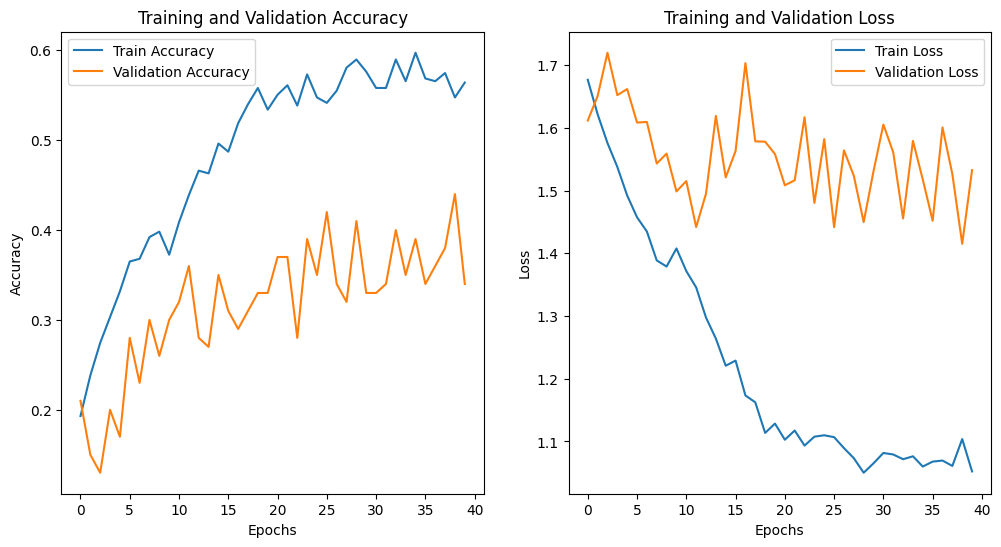

In [198]:
# Plotting function
def plot_training_conv3d(history):
    plt.figure(figsize=(12, 6))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_conv3d(history)


Overfitting:
Training accuracy reaches ~56% while validation accuracy stays around 34-44%
Validation loss often increases while training loss decreases
Large gap between training and validation metrics

Analysis
Looks like model is complex
Four Conv3D layers might be excessive
The architecture might be learning noise rather than meaningful features.



In [199]:
#Simlified architecture with early stopping

input_shape = (22, 128, 128, 3)  # Your current input shape
num_classes = 5

# Initialize Sequential model
model = Sequential()

# First Conv3D Block
model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.3))

# Second Conv3D Block
model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.4))

# Flatten and RNN
model.add(TimeDistributed(Flatten()))
model.add(GRU(64, dropout=0.3))

# Dense Layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))





In [200]:
# Compile the model
optimizer = Adam(learning_rate=5e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [201]:
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_24 (Conv3D)                   │ (None, 22, 128, 128, 32)    │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 22, 128, 128, 32)    │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_24 (MaxPooling3D)      │ (None, 11, 64, 64, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 11, 64, 64, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_25 (Conv3D)                   │ (None, 11, 64, 64, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 11, 64, 64, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_25 (MaxPooling3D)      │ (None, 5, 32, 32, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 5, 32, 32, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_163                 │ (None, 5, 65536)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 64)                  │      12,595,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,662,917 (48.31 MB)

 Trainable params: 12,662,725 (48.30 MB)

 Non-trainable params: 192 (768.00 B)

In [205]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

##

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print(steps_per_epoch,validation_steps)
print(num_epochs)


42 7
40


In [207]:
# Define callbacks
LR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='model_best.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Combine all callbacks
callbacks_list = [LR, checkpoint]

In [208]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path = C:\RNN\Project_data\Project_data\train ; batch size = 16
Number of folders: 663


C:\Users\azure\AppData\Local\Temp\2\ipykernel_4952\487364053.py:44: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(folder_path, imgs[item])).astype(np.float32)


Epoch 1/40
40/42 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.1898 - loss: 1.7538 

C:\Users\azure\AppData\Local\Temp\2\ipykernel_4952\487364053.py:99: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(folder_path, imgs[item])).astype(np.float32)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1895 - loss: 1.7522Source path = C:\RNN\Project_data\Project_data\val ; batch size = 16
Number of folders: 100

Epoch 1: val_loss improved from inf to 1.55152, saving model to model_best.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 211s 5s/step - accuracy: 0.1894 - loss: 1.7515 - val_accuracy: 0.3200 - val_loss: 1.5515 - learning_rate: 5.0000e-04
Epoch 2/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2107 - loss: 1.6712
Epoch 2: val_loss did not improve from 1.55152
42/42 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.2108 - loss: 1.6708 - val_accuracy: 0.2100 - val_loss: 1.6475 - learning_rate: 5.0000e-04
Epoch 3/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2177 - loss: 1.6524
Epoch 3: val_loss did not improve from 1.55152
42/42 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.2180 - loss: 1.6523 - val_accuracy: 0.1800 - val_loss: 1.6437 - learning_rate: 5.0000e-04
Epoch 4/40
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.

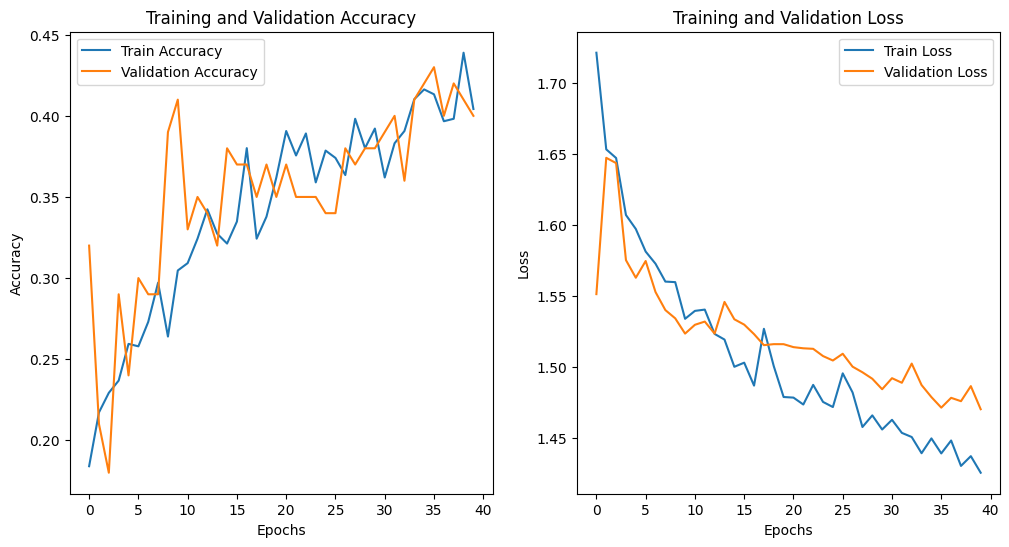

In [209]:
plot_training_conv3d(history)

Adding more layers, 

In [216]:
'''from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv3D, BatchNormalization, MaxPooling3D, Dropout
from tensorflow.keras.layers import Flatten, GRU, Dense, GlobalAveragePooling3D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Define input shape and parameters
input_shape = (22, 128, 128, 3)
num_classes = 5

# Initialize Sequential model
model = Sequential([
    # First Conv3D Block
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same', 
           input_shape=input_shape, kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(1, 2, 2)),
    Dropout(0.25),
    
    # Second Conv3D Block
    Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(1, 2, 2)),
    Dropout(0.25),
    
    # Third Conv3D Block
    Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(1, 2, 2)),
    Dropout(0.25),
    
    # Fourth Conv3D Block
    Conv3D(512, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv3D(512, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(1, 2, 2)),
    Dropout(0.25),
    
    # Fifth Conv3D Block - Added for more feature extraction
    Conv3D(512, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv3D(512, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 2, 2)),  # Now we reduce temporal dimension
    Dropout(0.25),
    
    # Global Average Pooling
    GlobalAveragePooling3D(),
    
    # Dense layers with residual connections
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

# Compile with optimized learning rate and gradient clipping
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Enhanced callbacks for better training
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='model_best.keras',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )
]'''

C:\Users\azure\AppData\Local\Temp\2\ipykernel_4952\487364053.py:44: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(folder_path, imgs[item])).astype(np.float32)


In [22]:
#model.summary()

#### Final Analysis

Throughout our experiments, the Conv2D + GRU architecture emerged as the most effective model for our gesture recognition task. By selecting 20 frames, increasing the epochs to 40, and balancing model complexity with regularization, we achieved a substantial improvement in validation accuracy, reaching approximately 72%.
1.	Frame Selection & Epochs: Increasing the number of frames and epochs proved crucial in enhancing model performance, as it provided a richer temporal context and allowed the model more time to converge.
2.	Simplified Architecture with GRU: While LSTMs struggled to generalize well on data, GRUs maintained a balance, leading to better validation performance.
3.	Regularization & Dropout: Regularization techniques like Dropout effectively reduced overfitting, particularly in complex architectures.
4.	Avoiding Overly Complex Layers: Deeper architectures with multiple Conv3D layers and high frame counts tended to overfit, learning noise rather than valuable features. Simplified Conv2D layers with GRU performed best by capturing temporal dynamics without excessive complexity.
Future improvements could include fine-tuning hyperparameters, experimenting with slightly lower batch sizes (if memory allows), and using techniques like learning rate scheduling to further refine convergence. Looks like, complex architectures often introduce noise, reaffirming that simpler, well-regularized models are often more robust for this type of sequential data.

